Epoch 1/500
875/875 [==============================] - 13s 14ms/step - loss: 3434.5364 - mae: 44.2232 - val_loss: 3203.4402 - val_mae: 44.7317
Epoch 2/500
875/875 [==============================] - 12s 14ms/step - loss: 2552.1914 - mae: 38.2481 - val_loss: 2583.5361 - val_mae: 40.0576
Epoch 3/500
875/875 [==============================] - 13s 14ms/step - loss: 1865.7322 - mae: 31.5231 - val_loss: 1934.1897 - val_mae: 33.2071
Epoch 4/500
875/875 [==============================] - 12s 14ms/step - loss: 1660.2655 - mae: 29.5169 - val_loss: 1640.0942 - val_mae: 29.8697
Epoch 5/500
875/875 [==============================] - 13s 15ms/step - loss: 1583.3917 - mae: 28.7467 - val_loss: 1595.9348 - val_mae: 29.3895
Epoch 6/500
875/875 [==============================] - 14s 15ms/step - loss: 1530.7423 - mae: 28.1374 - val_loss: 1524.9070 - val_mae: 28.3300
Epoch 7/500
875/875 [==============================] - 13s 14ms/step - loss: 1489.0718 - mae: 27.6594 - val_loss: 1442.9067 - val_mae: 27.1963

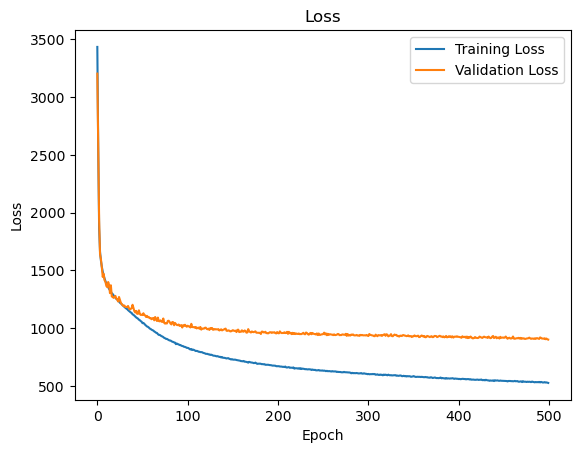

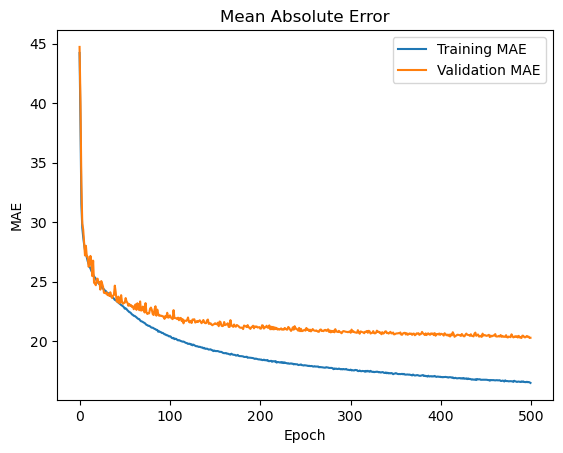

In [20]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.metrics import MeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import r2_score

# 이미지 데이터셋과 CSV 파일 경로
image_folder = "./sf_aug/"  # 이미지 폴더 경로
csv_file = "./joint_aug.csv"  # CSV 파일 경로

# 이미지 크기
image_size = (32, 32)

# 이미지 데이터(특징값) 불러오는 함수
def load_images(image_folder, image_size):
    images = []
    for filename in os.listdir(image_folder):
        img = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            _, binary_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            binary_image = binary_image.astype(np.uint8)
            distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
            img = cv2.resize(distance_transform, image_size)
            img = img.flatten()
            images.append(img)
    return np.array(images)

# CSV 파일 불러오는 함수
def load_csv(csv_file):
    df = pd.read_csv(csv_file)
    return df.values[:, 1:]  # 첫 번째 열(이미지 이름) 제외

# 이미지 데이터셋과 CSV 파일 로드
image_data = load_images(image_folder, image_size)
csv_data = load_csv(csv_file)

for i in range(len(csv_data)):
    if csv_data[i][6] > csv_data[i][10]:
        for j in range(6,10):
            tmp = csv_data[i][j]
            csv_data[i][j] = csv_data[i][j+4]
            csv_data[i][j+4] = tmp

    if csv_data[i][14] > csv_data[i][18]:
        for j in range(14,18):
            tmp = csv_data[i][j]
            csv_data[i][j] = csv_data[i][j+4]
            csv_data[i][j+4] = tmp

# 데이터셋 셔플링
indices = np.arange(len(csv_data))
np.random.shuffle(indices)
shuffled_images = image_data[indices]
shuffled_csv = csv_data[indices]


# 데이터셋 분할 (train:validation:test = 0.6:0.2:0.2)
train_images, test_images, train_csv, test_csv = train_test_split(shuffled_images, shuffled_csv, test_size=0.2, random_state=42)
train_images, val_images, train_csv, val_csv = train_test_split(train_images, train_csv, test_size=0.25, random_state=42)

# 데이터 전처리 (입력 이미지와 목표값 간의 매핑 필요)
x_train = train_images.reshape(-1, *image_size, 1).astype('float32') / 255.0
y_train = train_csv.astype('float32')

x_val = val_images.reshape(-1, *image_size, 1).astype('float32') / 255.0
y_val = val_csv.astype('float32')

x_test = test_images.reshape(-1, *image_size, 1).astype('float32') / 255.0
y_test = test_csv.astype('float32')

# 모델 구축
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(22))

# 모델 컴파일
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val))

# 예측
y_pred = model.predict(x_test)

# R^2 점수 계산
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

print(train_images.shape)
print(train_csv.shape)
print(test_images.shape)
print(test_csv.shape)
print(val_images.shape)
print(val_csv.shape)


# 손실과 정확도 그래프 그리기
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


1/1 [==============================] - 0s 19ms/step
x_ex 예측 좌표값: [[172.49698  124.539665 198.58052  147.35806  205.29373  142.47578
  161.97481  167.49977  147.31625  195.07925  217.129    188.76193
  215.51     217.90482  118.26872  108.88872   75.51011   77.9933
  178.6143   143.17621  186.29153  153.07768 ]]
실제 x_ex 좌표값: []
오차: []
오차 평균의 절대값: nan


c:\Users\isshe\anaconda3\envs\sf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\isshe\anaconda3\envs\sf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


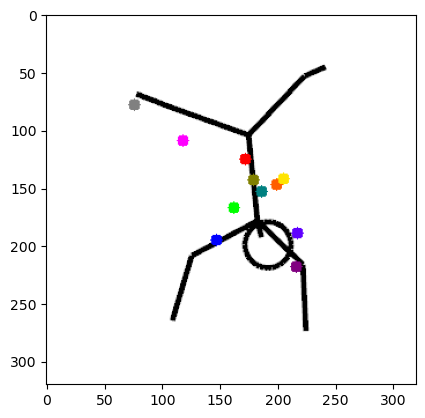

In [21]:


ex_image = load_images("./image_ex/", image_size)
ex_csv = load_csv("./joint_ex.csv")

x_ex = ex_image.reshape(-1, *image_size, 1).astype('float32') / 255.0
y_ex = ex_csv.astype('float32')

predictions = model.predict(x_ex)

print("x_ex 예측 좌표값:", predictions)  
print("실제 x_ex 좌표값:", ex_csv)
print("오차:", predictions - ex_csv)

# 오차 평균 구하기
average = np.mean(abs(predictions - y_ex))
print("오차 평균의 절대값:", abs(average))

imageFile = './image_ex/sf001782.png'
X_ex_image = cv2.imread(imageFile)

# 각 관절 위치 값 저장
data=predictions[0]

c1_x = int(round(data[0]))           
c1_y = int(round(data[1]))            
c2_x = int(round(data[2]))             
c2_y = int(round(data[3]))             
c3_x = int(round(data[4]))             
c3_y = int(round(data[5]))             
le_x = int(round(data[6]))             
le_y = int(round(data[7]))            
lh_x = int(round(data[8]))             
lh_y = int(round(data[9]))             
re_x = int(round(data[10]))             
re_y = int(round(data[11]))             
rh_x = int(round(data[12]))             
rh_y = int(round(data[13]))             
lk_x = int(round(data[14]))             
lk_y = int(round(data[15]))              
lf_x = int(round(data[16]))             
lf_y = int(round(data[17]))             
rk_x = int(round(data[18]))             
rk_y = int(round(data[19]))             
rf_x = int(round(data[20]))             
rf_y = int(round(data[21]))  



cv2.circle(X_ex_image,(c1_x,c1_y), radius=5, color=(0,0,255), thickness=-1)  #빨
cv2.circle(X_ex_image,(c2_x,c2_y), radius=5, color=(0,94,255), thickness=-1)  #주
cv2.circle(X_ex_image,(c3_x,c3_y), radius=5, color=(0,228,255), thickness=-1) #노
cv2.circle(X_ex_image,(le_x,le_y), radius=5, color=(0,255,0), thickness=-1)  #초
cv2.circle(X_ex_image,(lh_x,lh_y), radius=5, color=(255,0,0), thickness=-1)  #파
cv2.circle(X_ex_image,(re_x,re_y), radius=5, color=(255,0,95), thickness=-1)
cv2.circle(X_ex_image,(rh_x,rh_y), radius=5, color=(128,0,128), thickness=-1)
cv2.circle(X_ex_image,(lk_x,lk_y), radius=5, color=(255,0,255), thickness=-1)
cv2.circle(X_ex_image,(lf_x,lf_y), radius=5, color=(128,128,128), thickness=-1)
cv2.circle(X_ex_image,(rk_x,rk_y), radius=5, color=(0,128,128), thickness=-1)
cv2.circle(X_ex_image,(rf_x,rf_y), radius=5, color=(128,128,0), thickness=-1)


img = cv2.cvtColor(X_ex_image, cv2.COLOR_BGR2RGB)

#이미지, 점 출력
plt.imshow(img)
plt.show()